In [1]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import cv2

## 

## Edge detection

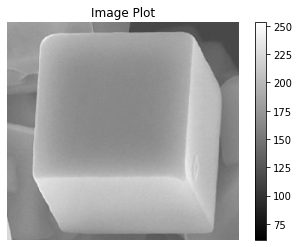

In [2]:
# get the particle
SEM_image_path = 'SEM_images/cubic_Ag3PO4_example.png'
particle = cv2.imread(SEM_image_path)

# Plot the image
plt.imshow(particle, cmap='gray')
plt.colorbar()
plt.title("Image Plot")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

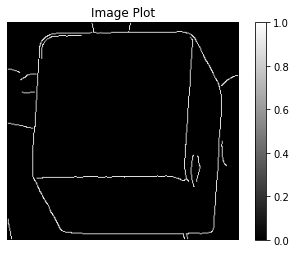

In [5]:
edge = edge_finder(particle)

# Plot the image
plt.imshow(edge, cmap='gray')
plt.colorbar()
plt.title("Image Plot")
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()